In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# import os
import re
# import math
import time
# import timeit

import sounddevice as sd
from scipy.io import wavfile
# import IPython.display as ipd
# import soundfile as sf

from multiprocess import Pool
import functools
import pdb

import sys
sys.path.insert(1, './functions')

from workflow import *
from read import *
from similarity import *
from helper import *
from display import *

In [2]:
# import session_info
# session_info.show()

In [3]:
sd.query_devices()
# sd.default.device = 3

> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)

In [4]:
samplerate, piano_audio = read_audio('Audio.wav')

/Users/snehashah/Desktop/Stagecast/stagecast-dev/./functions/read.py:53: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, piano_audio = wavfile.read(filePath)


In [5]:
sd.play(piano_audio, samplerate)

In [6]:
sd.stop()

0.8431595738095238
0.8340741285714286
0.8552021990909091
0.827930964
0.8479866591304348
0.8629653713207546
0.8791256211290325
0.8869386995588234
0.8989786902
0.9005435440588235
0.9092878021978021
0.9056837795360824
0.918164678773585
0.9155008465624999
0.9223584088235294
0.9283320081250002
0.9348677847368422
0.939584606115108
0.9484823476351352
0.9567110782165604
0.9619879442073169
0.9661989859714286
0.9719848073913042
0.8697224057142857
0.9037845964285715
0.8839209886363636
0.80548834325
0.8915457551063829
0.9012423933962265
0.8781832403225805
0.9165499830882353
0.9246618678
0.924373291764706
0.91886086989011
0.928317107755102
0.9378732425471699
0.9317498164601771
0.9386799114705882
0.9446296605468749
0.9497144106015039
0.9540633034892085
0.9621604668918919
0.9694568239171975
0.9683468246084337
0.9794459261363637
0.9845836402702703
0.8897853209999999
0.9028167466666668
0.8880821866666666
0.8723016842105262
0.8903151356382979
0.8987571541509434
0.9053207139166668
0.9173403848529412
0.90

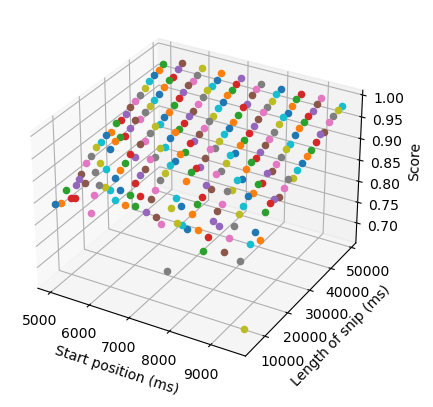

In [7]:
# Testing the above similarity score with different snippets of different playthroughs that "should" have a good score

midiPath = '../midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# matches=[]
for x in range(5000,10000,500):
#     print(x)
#     x = 0
    for y in range(5000,50000,2000):
        t1 = [y+x,0+x] # timestamps in ms
        t2 = [191400+y+x,191400+x]
#         t2 = [413000+y+x,413000+x]
#         t2 = [587000+y+x,587000+x]

        tf1 = time_to_sequence(notes, t1)
        tf2 = time_to_sequence(notes, t2)

        a,b,c,d,score = two_way_similarity(tf1,tf2,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,disp=True)
        print(score)
#         matches.append([x,y,score])
        ax.scatter(x,y,score)
        if score<0.8:
            print("  Oops")
#             a,b,c,d,score = two_way_similarity(tf1,tf2,zero_penalty=1,length_incentive=500000,max_offset=600,min_dist_const=400,disp=True)
#             display_snippet_plot(notes, time_to_index(notes,t1[0]),time_to_index(notes,t1[1]),time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), score, t1[0], t2[0])
    #         play_match(piano_audio, t1[0],t1[1],t2[0],t2[1])
    #         predict(notes, time_to_index(notes,t1[0]), time_to_index(notes,t1[1]), time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), tf1[-1][0],pred_time=100,sound=True)
    #         time.sleep(2)
#         break
#     break

# plt.scatter3D(matches)
ax.set_xlabel('Start position (ms)')
ax.set_ylabel('Length of snip (ms)')
ax.set_zlabel('Score')
plt.show()

In [8]:
# Setting up parameters to run the matching algorithm

midiPath = '../midi-recordings/ladispute.txt'
notes = midi_to_timeseries(midiPath)

# hyperparameters
zero_penalty = 1
length_incentive = 500000 # 50 seconds yields 10% increase in score
max_offset = 600
timestamp_max_before_source = 5000 #ms behing the source timestamp
min_dist_const = 400 # acceptable time difference for same note
initial_alignment = "last note in source to match in target"
realignment = "mean offset of notes within max_offset dist - done once"
note_scoring = "penalize within min_dist"

# parameters
minNotes = 8
maxNotes = 200 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxTime = 30000 # if more matches, increase snippet length
thresh = 0.7
start = 191400
skip = 10
end = 365000

fm = functools.partial(find_matches_at_timestamp, notes=notes, minNotes=minNotes, minTime=minTime, maxNotes=maxNotes, 
                       maxTime=maxTime, thresh=thresh, timestamp_max_before_source=timestamp_max_before_source, 
                       zero_penalty=zero_penalty, length_incentive=length_incentive, max_offset=max_offset, 
                       min_dist_const=min_dist_const, disp=False)

# Running with time allocation to functions - analyse speed and bottlenecks
# %prun sims_arr.extend(find_matches_at_timestamp(25000, notes, minNotes, minTime, maxNotes, maxTime, thresh, disp=False))



In [ ]:
# Running match algorithm parallely

fm(25000)

sims_arr = []
curr_times = np.arange(start, end, skip)

with Pool(4) as p:
    sims_arr = p.map(fm, curr_times)

# storing matches as array of all matches
sarr = []
for i in range(len(sims_arr)):
    sarr.extend(sims_arr[i])

i: 25000    191400    202250    213100    223950    191410    202260    213110    191420    202270    223960    191430    202280    213120    191440    202290    223970    191450    202300    213130    191460    202310    223980    213140    191470    202320    191480    223990    213150    202330    191490    202340    213160    191500    224000    202350    191510    213170    202360    224010   i:191520    202370    213180    191530    202380    224020    191540    202390    213190    202400    191550    224030   i: 213200202410       191560    202420    224040    191570    213210    202430    202440    191580    224050    213220    202450    191590    202460    213230    224060    191600    202470    202480    191610    213240    202490    224070    191620    202500    213250    191630    202510    224080    202520    191640    213260    202530    191650    224090    213270    202540    191660    202550    224100    191670    213280    202560    191680    202570    213290    224110

In [ ]:
# simsDF_1 = simsDF_old
# simsDFall_1 = simsDFall_old
# simsDF_2 = simsDF_old
# simsDFall_2 = simsDFall_old
# simsDF_old = simsDF
# simsDFall_old = simsDFall


In [ ]:
## choosing only significant scores and storing the new data in sims_plot

sarr = np.array(sarr)
sims_thresh = sarr * (sarr>thresh) # considering a match if score greater than a threshold

simsDF = pd.DataFrame(data=sims_thresh.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
simsDFall = pd.DataFrame(data=sarr.copy(), columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])


In [ ]:
# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Notes=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


In [ ]:
# Plotting best match only

percentage_matches_any = 0
percentage_matches_thresh = 0
percentage_matches_line = 0
percentage_matches_thresh_line = 0
acc = 50                            #ms accuracy for distance from line

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True
bestMatches = []

toPlot = simsDFall
# toPlot = simsDFall_old

total = 0
distribution_hist = []
distribution_all = []
close_matches = []
min_good_score = 1
for x in range(start,end,skip):
    y = toPlot.loc[toPlot['source_timestamp'] == x]['score']
    total += 1
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if toPlot['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
            if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
                percentage_matches_thresh_line += 1
        if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
            if toPlot['score'].loc[y] < min_good_score:
                min_good_score = toPlot['score'].loc[y]
            distribution_hist.append((toPlot['target_timestamp'].loc[y]-(x-191400)))
            distribution_all.append([x,(toPlot['target_timestamp'].loc[y]-(x-191400))])
            percentage_matches_line += 1
            close_matches.append(toPlot.loc[y].tolist())
    else:
        continue
#     bestMatch = [toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],toPlot['source_id_start'].loc[y],toPlot['source_id_end'].loc[y],toPlot['target_id_start'].loc[y],toPlot['target_id_end'].loc[y]]
#     bestMatches.append(bestMatch)
    plt.scatter(toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],c='blue')
# bestMatches = np.array(bestMatches)
# bestMatchesDF = pd.DataFrame(data=bestMatches, columns=["source_timestamp","target_timestamp", "score", "source_id_start", "source_id_end", "target_id_start", "target_id_end"])   

plt.plot(np.arange(170000,400000),np.arange(170000,400000))
plt.plot(np.arange(191400,391400),np.arange(200000))
percentage_matches_any /= total
percentage_matches_thresh /= total
percentage_matches_line /= total
percentage_matches_thresh_line /= total
print("Percentage matches found: {:.1f}%".format(percentage_matches_any*100))
print("Percentage matches >{:.1f} found: {:.1f}%".format(thresh,percentage_matches_thresh*100))
print("Percentage matches within {:d}ms of line: {:.1f}%".format(acc,percentage_matches_line*100))
print("Percentage matches >{:.1f} and within {:d}ms of the line: {:.1f}%".format(thresh,acc,percentage_matches_thresh_line*100))
print("Minimum score of a \"right match\": {:.2f}".format(min_good_score))

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Timestamp")
plt.show()


In [ ]:
# also plot histogram
mean = np.mean(distribution_hist)
std = np.std(distribution_hist)
print("Distribution Mean:{:.2f}".format(mean))
print("Distribution Standad Deviation:{:.2f}".format(std))
plt.hist(distribution_hist,bins=int(max(distribution_hist)-min(distribution_hist)))
plt.title("Histogram of time difference from expected")
plt.xlabel("Time difference (ms)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Note distribution in first vs second playthrough

note_distribution_hist = []
for note in notes[time_to_index(notes,start):time_to_index(notes,end)]:
    # find closest note in history
    note2 = find_note(notes, note[0]-191400, note[1], max_time_dist = 100)
    if note2:
        note_distribution_hist.append(note[0]-notes[note2][0]-191400)
    
mean = np.mean(note_distribution_hist)
std = np.std(note_distribution_hist)
print("Distribution Mean:{:.2f}".format(mean))
print("Distribution Standad Deviation:{:.2f}".format(std))
plt.hist(note_distribution_hist,bins=int(max(note_distribution_hist)-min(note_distribution_hist)))
plt.title("Histogram of actual note deviation accross performances")
plt.xlabel("Time difference (ms)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time']
k = 1

# dtype = [('source_timestamp', float), ('target_timestamp', float), ('score', float),('source_id_start', float),\
#          ('source_id_end', float),('target_id_start', float),('target_id_end', float),('match_len', float),('match_time', float)]

close_matches_array = np.array(close_matches)
distribution_hist_array = np.array(distribution_hist)
print(close_matches_array.shape)
close_matches_df = pd.DataFrame(data = close_matches_array, columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
close_matches_df['deviation'] = distribution_hist_array

close_matches_sorted = close_matches_df.sort_values(by=['deviation'])

worst_matches = np.array(close_matches_sorted.iloc[-k:],dtype=float)

print(close_matches_df.iloc[0])
print(worst_matches.shape)
print(worst_matches.astype(int))
for match in worst_matches:
    print(match.astype(int))
    source_start = int(match[0])
    target_start = int(match[1])
    score = match[2]
    source_id_start = int(match[3])
    source_id_end = int(match[4])
    target_id_start = int(match[5])
    target_id_end = int(match[6])
    match_len = int(match[7])
    match_time = int(match[8])
    
    # plot worst match (in terms of distance from expected timestamp)
    diff = source_start - target_start
    sequence1 = np.copy(notes[source_id_end:source_id_start+3])
    sequence1[:,0] = sequence1[:,0]-diff
    sequence2 = np.copy(notes[target_id_end:target_id_start+3])
    sequence2[:,0] = sequence2[:,0]
    sequence3 = sequence2.copy()
    sequence3[:,0] = sequence2[:,0]-diff+191400
    
    display_expected_actual(sequence1,sequence2,source_start,target_start,source_start-diff,target_start,source_start-191400,diff,score,match_time,l1="Source",l2="Matching Target",l3="Expected Target")
    display_expected_actual(sequence1,sequence3,source_start,target_start,source_start-191400,source_start-191400,target_start,diff,score,match_time,l1="Source",l2="Expected Target",l3="Matching Target")
    
    a = notes[source_id_start-2:source_id_start+3]
    b = notes[target_id_start-2:target_id_start+3]
    print("Source end notes:\n",a)
    print("Source end notes - 191400:",a[:,0] - 191400)
    print("Target end notes:\n",b)
    print("Source diff between notes:",a[1:,0] - a[:-1,0])
    print("Target diff between notes:",b[1:,0] - b[:-1,0])
    print("Source time - last note:",match[0]-notes[int(match[3])-1][0])
    print("Target time - last note:",match[1]-notes[int(match[5])-1][0])
    print()

In [ ]:
# Plotting diff vs source time

distribution_all_arr = np.array(distribution_all)
plt.plot(distribution_all_arr[:,0],distribution_all_arr[:,1])
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Target Timestamp Deviation from Expected (ms)")
plt.title("Plot showing time difference betweeen Best Match and Expected Match for every source time in second playthrough")
plt.show()

In [ ]:
# Plotting diff vs source time - within a range

source_time = 275000
index = (source_time - start)//skip
# index -= 1500
len_match = 500

# Getting match details near source time we're interested in
# Can use this to make display_snippet plots
# matches_near_source = np.array(close_matches_df.iloc[index:index+500])

distribution_all_arr = np.array(distribution_all)
plt.plot(distribution_all_arr[index:index+len_match,0],distribution_all_arr[index:index+len_match,1])
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Target Timestamp Deviation from Expected (ms)")
plt.title("Plot showing time difference betweeen Best Match and Expected Match")
plt.show()

In [ ]:
pop_a = mpatches.Patch(color='blue', label='Unexpected match')
pop_b = mpatches.Patch(color='orange', label='On the line match')

In [ ]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in curr_times:
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    else:
        if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
            color = 'orange'
        else:
            color = 'blue'
        plt.scatter(x,y,1,c=color) # need to include s (len of best match)

# currDF = simsDFall.copy()
# currDF.sort_values(['source_timestamp', 'score', 'match_len'], ascending=[True, False, False]).drop_duplicates(['source_timestamp']).reset_index(drop=True)
# plt.scatter(curr_times,currDF.loc[currDF['source_timestamp'] == curr_times]['score'],currDF.loc[currDF['source_timestamp'] == curr_times]['match_len'])
# scores = s.max(axis = 0)
# # if np.isnan(y):
# #     count += 1
# #     y = 0
    

print(count)
plt.title("Best match score for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Score")
plt.legend(handles=[pop_a,pop_b])
plt.show()

In [ ]:
# Plotting note length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    
    if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(x,s,1,c=color)
    
# print(count)
plt.title("Best match length (in notes) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (#notes)")
plt.legend(handles=[pop_a,pop_b])
plt.show()

In [ ]:
# Plotting time length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_time'].max()
#     print(s)
    if np.isnan(y):
        count += 1
        y = 0
    if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_time'] == s)]['target_timestamp']-(x-191400))<100).any():
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(x,s,1,c=color)
    
# print(count)
plt.title("Best match length (in time) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (ms)")
plt.legend(handles=[pop_a,pop_b])
plt.show()